# The project objective is to train a deep learning model that can solve a Sudoku puzzle. The problem has been divided into two tasks.

# Task 2: Solving Sudoku puzzle (MLP MODEL)

# Goal: To complete the Sudoku puzzles by filling in all missing digits in all the test images.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
data = pd.read_csv("/kaggle/input/sudoko-lstm/trained_output.csv")

In [2]:
class SudokuDataset(Dataset):
    def __init__(self, dataframe, subset="train"):
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle = self.dataframe.iloc[idx, 0]
        solution = self.dataframe.iloc[idx, 1]

        puzzle = torch.tensor([int(p) for p in puzzle], dtype=torch.float32).reshape(1, 9, 9) / 9 - 0.5
        if self.subset == 'train':
            solution = torch.tensor([int(s) - 1 for s in solution], dtype=torch.int64).reshape(9, 9)  
            return puzzle, solution.view(-1)
        return puzzle

In [3]:
train_idx = int(len(data) * 0.75)
train_data = SudokuDataset(data.iloc[:train_idx], subset="train")
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)

val_data = SudokuDataset(data.iloc[train_idx:], subset="train")
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedSudokuSolverMLP(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ImprovedSudokuSolverMLP, self).__init__()
        
        # Replace convolutional layers with fully connected layers
        self.fc1 = nn.Linear(1 * 9 * 9, 32)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(64, 128)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.fc4 = nn.Linear(128, 128)
        self.dropout4 = nn.Dropout(p=dropout_rate)
        self.fc5 = nn.Linear(128, 256)
        self.dropout5 = nn.Dropout(p=dropout_rate)
        self.fc6 = nn.Linear(256, 81 * 9)
        self.dropout6 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = F.relu(self.dropout1(self.fc1(x)))
        x = F.relu(self.dropout2(self.fc2(x)))
        x = F.relu(self.dropout3(self.fc3(x)))
        x = F.relu(self.dropout4(self.fc4(x)))
        x = F.relu(self.dropout5(self.fc5(x)))
        x = F.relu(self.dropout6(self.fc6(x)))
        return x.view(-1, 9)

model = ImprovedSudokuSolverMLP()


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [30]:
import matplotlib.pyplot as plt


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        # Training Phase
        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()

                val_correct += calculate_accuracy(outputs, solutions.view(-1)) * solutions.size(0)
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / total_val

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [31]:
print(model)

ImprovedSudokuSolverMLP(
  (fc1): Linear(in_features=81, out_features=32, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=128, out_features=256, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (fc6): Linear(in_features=256, out_features=729, bias=True)
  (dropout6): Dropout(p=0.5, inplace=False)
)


Epoch 1: Train Loss: 2.1976, Train Accuracy: 0.1109, Validation Loss: 2.1972, Validation Accuracy: 0.1110
Epoch 2: Train Loss: 2.1973, Train Accuracy: 0.1111, Validation Loss: 2.1972, Validation Accuracy: 0.1111
Epoch 3: Train Loss: 2.1972, Train Accuracy: 0.1114, Validation Loss: 2.1972, Validation Accuracy: 0.1105
Epoch 4: Train Loss: 2.1972, Train Accuracy: 0.1113, Validation Loss: 2.1972, Validation Accuracy: 0.1113
Epoch 5: Train Loss: 2.1972, Train Accuracy: 0.1114, Validation Loss: 2.1972, Validation Accuracy: 0.1108
Epoch 6: Train Loss: 2.1972, Train Accuracy: 0.1111, Validation Loss: 2.1972, Validation Accuracy: 0.1109
Epoch 7: Train Loss: 2.1972, Train Accuracy: 0.1111, Validation Loss: 2.1972, Validation Accuracy: 0.1104
Epoch 8: Train Loss: 2.1972, Train Accuracy: 0.1110, Validation Loss: 2.1972, Validation Accuracy: 0.1105
Epoch 9: Train Loss: 2.1972, Train Accuracy: 0.1110, Validation Loss: 2.1972, Validation Accuracy: 0.1102
Epoch 10: Train Loss: 2.1972, Train Accuracy: 

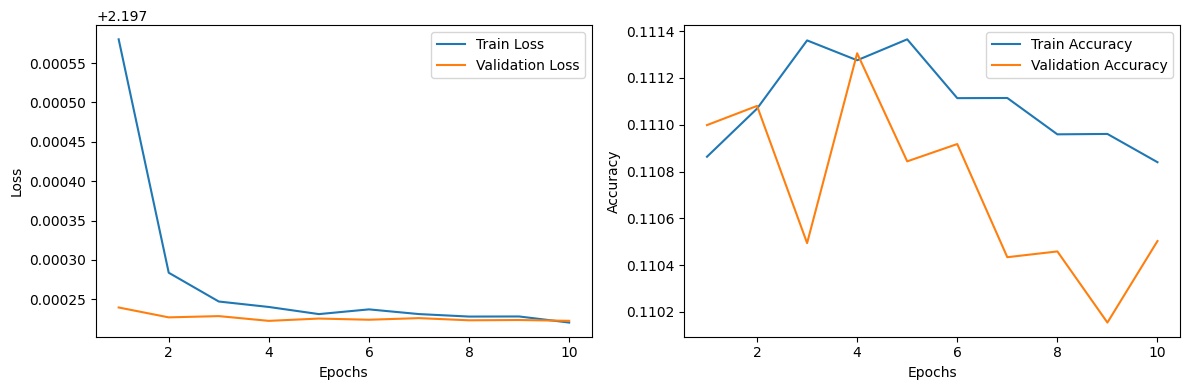

In [32]:
train_model(model, train_loader, val_loader, epochs=10)

In [ ]:
# predict on the entire test set
predicted_solutions = predict_test_set(model, test)

In [ ]:
indexes = []
labels= []
#for i,j in enumerate(predicted_solutions_df["predicted_solution"]):
for i,j in enumerate(predicted_solutions):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(preds[row,col])

In [ ]:
Test_Predictions.to_csv("Test_Predictions8.csv", index=False)